<a href="https://colab.research.google.com/github/Dhamu785/AI-scratch/blob/main/PyTorch/05_custom_data_in_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. ⏬Import libaries**

In [1]:
import torch as t
import torchvision as tv
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
print(f"Torch version = {t.__version__}")
print(f"TorchVision version = {tv.__version__}")

Torch version = 2.3.1+cu121
TorchVision version = 0.18.1+cu121


In [3]:
import requests
import zipfile
from pathlib import Path
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import math
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
import multiprocessing

num_cpus = multiprocessing.cpu_count()
num_cpus

2

In [6]:
device = 'cuda' if t.cuda.is_available() else 'cpu'
print(f"Current device = {device}")

Current device = cpu


## **2. 🔽Download data - [tv](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html)**

In [7]:
master_dir = Path("/content/drive/MyDrive/Colab Notebooks YouTube tutorials/8.1 PyTorch/01_Daniel Bourke/data")
fldr_name = Path("05_food")
zip_file = master_dir / fldr_name
img_file = master_dir / fldr_name / "Images"

# Creating the folder for the data

if img_file.is_dir():
    print("Folder already exists...")
else:
    print("Creating the folder...")
    img_file.mkdir(parents=True, exist_ok=True)

    # Downloading the data
    with open(zip_file/"foods.zip", "wb") as f:
        data = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip").content
        print("Downloading the zip file...")
        f.write(data)

    # unzip the file
    with zipfile.ZipFile(zip_file/"foods.zip", 'r') as zipread:
        print("UnZipping the files...")
        zipread.extractall(img_file)

Folder already exists...


## **3. 📈Explore the data**

In [8]:
def check_paths(path):
    for folder_path, folder, files in os.walk(path):
        print(f"{folder_path.split('/')[-1]} -> {folder} -> {len(files)} files")

In [9]:
check_paths(img_file)

Images -> ['test', 'train'] -> 0 files
test -> ['pizza', 'steak', 'sushi'] -> 0 files
pizza -> [] -> 25 files
steak -> [] -> 19 files
sushi -> [] -> 31 files
train -> ['pizza', 'steak', 'sushi'] -> 0 files
pizza -> [] -> 78 files
steak -> [] -> 75 files
sushi -> [] -> 72 files


In [10]:
# Settingup the path for train dir and test dir

test_dir = img_file / "test"
train_dir = img_file / "train"

test_dir, train_dir

(PosixPath('/content/drive/MyDrive/Colab Notebooks YouTube tutorials/8.1 PyTorch/01_Daniel Bourke/data/05_food/Images/test'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks YouTube tutorials/8.1 PyTorch/01_Daniel Bourke/data/05_food/Images/train'))

### **3.1 Data visualize**

In [11]:
test_dir.parent.stem

'Images'

Image path = /content/drive/MyDrive/Colab Notebooks YouTube tutorials/8.1 PyTorch/01_Daniel Bourke/data/05_food/Images/test/sushi/1742201.jpg
Image height= 512, Image_width= 512, Image shape = (512, 512, 3)
Class name = sushi


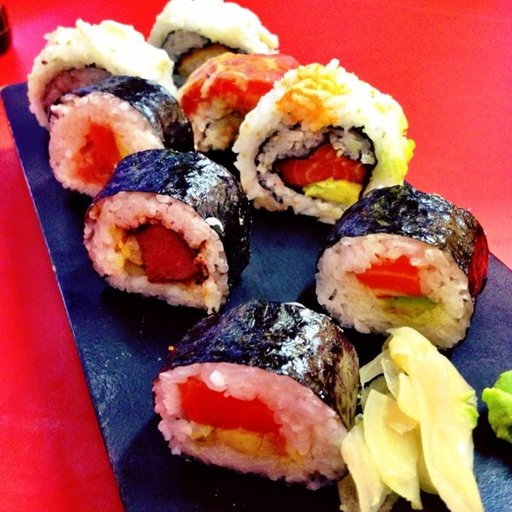

In [12]:
random.seed(42)

all_images = list(img_file.glob("*/*/*.jpg"))
img_path_random = random.choice(all_images)

cls_name = img_path_random.parent.stem
img = Image.open(img_path_random)

print(f"Image path = {img_path_random}")
print(f"Image height= {img.height}, Image_width= {img.width}, Image shape = {np.array(img).shape}")
print(f"Class name = {cls_name}")
img

## **4. Turning images into Tensor**

### **Option-1**

#### **4.1.1 Image Folder**

In [13]:
data_transform = transforms.Compose([
    transforms.Resize((244,244)),
    transforms.RandomHorizontalFlip(0.50),
    transforms.ToTensor()
])

In [14]:
transformed = data_transform(img)
transformed.shape, transformed.dtype

(torch.Size([3, 244, 244]), torch.float32)

In [15]:
def plot_transformed_image(img_list:list, transform, samples:int, seed:int | None=None):
    if seed:
        random.seed(seed)
    samples = random.sample(img_list, samples)
    for image in samples:
        with Image.open(image) as i:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(i)
            ax[0].set_title(f"Original\nsize={i.size}")
            ax[0].axis('off')

            trans = transform(i).permute(1,2,0)
            ax[1].imshow(trans)
            ax[1].set_title(f"Transformed image\nsize={trans.shape}")
            ax[1].axis('off')

            fig.suptitle("Class test", fontsize=16)

# plt.imshow(transformed.permute(1,2,0))

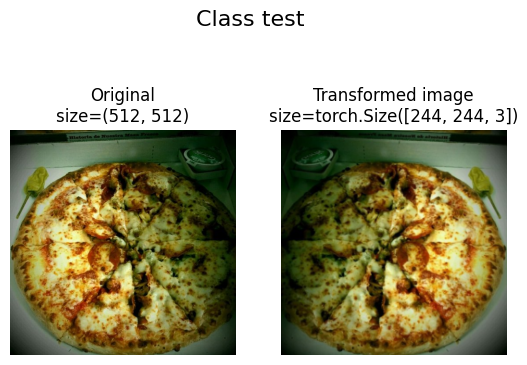

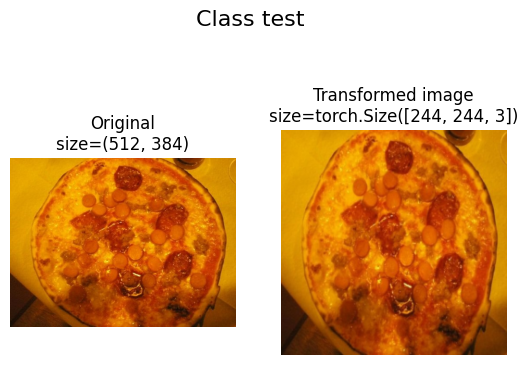

In [16]:
plot_transformed_image(all_images, data_transform, 2)

In [17]:
train_data = datasets.ImageFolder(root=train_dir, transform = data_transform, target_transform=None)
test_data = datasets.ImageFolder(test_dir, data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: /content/drive/MyDrive/Colab Notebooks YouTube tutorials/8.1 PyTorch/01_Daniel Bourke/data/05_food/Images/train
     StandardTransform
 Transform: Compose(
                Resize(size=(244, 244), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: /content/drive/MyDrive/Colab Notebooks YouTube tutorials/8.1 PyTorch/01_Daniel Bourke/data/05_food/Images/test
     StandardTransform
 Transform: Compose(
                Resize(size=(244, 244), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [18]:
for i in dir(train_data):
    print(i, end=' || ')

__add__ || __annotations__ || __class__ || __class_getitem__ || __delattr__ || __dict__ || __dir__ || __doc__ || __eq__ || __format__ || __ge__ || __getattribute__ || __getitem__ || __gt__ || __hash__ || __init__ || __init_subclass__ || __le__ || __len__ || __lt__ || __module__ || __ne__ || __new__ || __orig_bases__ || __parameters__ || __reduce__ || __reduce_ex__ || __repr__ || __setattr__ || __sizeof__ || __slots__ || __str__ || __subclasshook__ || __weakref__ || _format_transform_repr || _is_protocol || _repr_indent || class_to_idx || classes || extensions || extra_repr || find_classes || imgs || loader || make_dataset || root || samples || target_transform || targets || transform || transforms || 

In [19]:
test_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
test_data.classes

['pizza', 'steak', 'sushi']

In [21]:
test_data.transforms

StandardTransform
Transform: Compose(
               Resize(size=(244, 244), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [22]:
test_data.transform

Compose(
    Resize(size=(244, 244), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)

#### **4.1.2 Data Loaders**

In [23]:
train_dataloader = DataLoader(dataset=train_data, batch_size=2, num_workers=2, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=2, num_workers=2, shuffle=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ef6d76da650>,
 <torch.utils.data.dataloader.DataLoader at 0x7ef6d728b5b0>)

In [24]:
len(train_dataloader)

113

In [25]:
img, label = next(iter(test_dataloader))
img.shape, label.shape

(torch.Size([2, 3, 244, 244]), torch.Size([2]))

### **Option-2**
**Pros**
- Can able to create any type of data.

**Cons**
- Performance issue.
- Will not work as same as in-build function.

#### **4.2.1 Fetch class names**

In [26]:
from typing import Tuple, List, Dict

In [27]:
r = ["yes" if os.path.isdir(train_dir/i) else "no" for i in os.listdir(train_dir)]
r

['yes', 'yes', 'yes']

In [28]:
def find_class(path:pathlib.PosixPath) -> Tuple[List[str], Dict[str,int]]:
    classes = [i for i in os.listdir(path) if os.path.isdir(path/i)]
    if not classes:
        raise FileNotFoundError("No classes found...")

    cls_dict = {name:i for i,name in enumerate(os.listdir(path)) if os.path.isdir(path/name)}
    return (classes, cls_dict)
    # print(classes)

In [29]:
find_class(test_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### **4.2.2 Create custom dataset reader**

In [30]:
class ImageDataRead(Dataset):
    def __init__(self, path:str, transform=None):
        self.paths = list(Path(path).glob('*/*.jpg'))
        self.transform = transform
        self.classes, self.class_to_idx = find_class(path)

    def open_file(self, idx:int) -> Image.Image:
        img_path = self.paths[idx]
        return Image.open(img_path)

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, idx:int) ->Tuple[t.Tensor, int]:
        img_data = self.open_file(idx)
        cls_name = self.paths[idx].parent.name
        index = self.class_to_idx[cls_name]

        if self.transform:
            return self.transform(img_data), index
        else:
            compose = transforms.Compose([transforms.ToTensor()])
            return compose(img), index


In [31]:
# create a transforms

train_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64,63)),
    transforms.ToTensor()
])

In [32]:
# fitting the images into the data reader

ctest_data = ImageDataRead(test_dir, train_transform)
ctrain_data = ImageDataRead(train_dir, test_transform)

ctrain_data, ctest_data

(<__main__.ImageDataRead at 0x7ef6d3f27550>,
 <__main__.ImageDataRead at 0x7ef6d3f26ad0>)

In [33]:
len(ctrain_data), len(ctest_data)

(225, 75)

In [34]:
print(test_data.classes==ctest_data.classes)
print(train_data.classes==ctrain_data.classes)

True
True


In [35]:
class d:
    def __init__(self):
        pass
    def __repr__(self):
        return "from repr"

    def __str__(self):
        return "from str"

aa = d()
print(aa)
aa

from str


from repr

#### **4.2.3 Visualize the data**

In [36]:
def plot_random_images(data:datasets, classes:List, n:int, shape:bool|bool=True, seed:int | None=None) -> None:

    if n >= 10:
        n = 10
        shape=False
        print("For display purpose it is set to 10 samples, with shape=False...")

    if seed:
        random.seed(seed)

    samples = random.sample(range(len(data)), k=n)

    plt.figure(figsize=(16,5))
    for i,idx in enumerate(samples):
        img_data, lbl = data[idx]
        reshaped = img_data.permute(1,2,0)

        plt.subplot(1, n, i+1)
        plt.imshow(reshaped)
        plt.axis('off')
        if shape:
            title = f'{classes[lbl]}\nshape:{np.array(reshaped.shape)}'
            plt.title(title, fontsize=8)
        else:
            title = classes[lbl]
            plt.title(title)

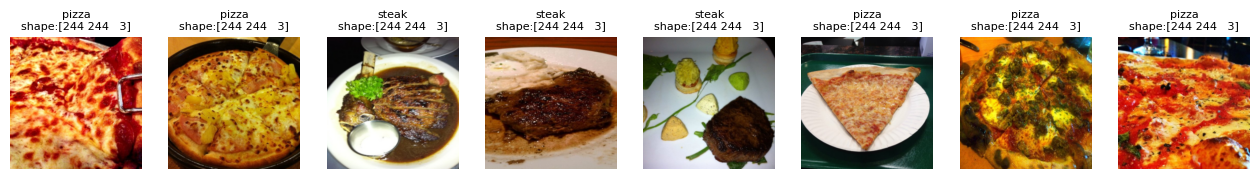

In [37]:
plot_random_images(test_data, test_data.classes, 8, seed=42)

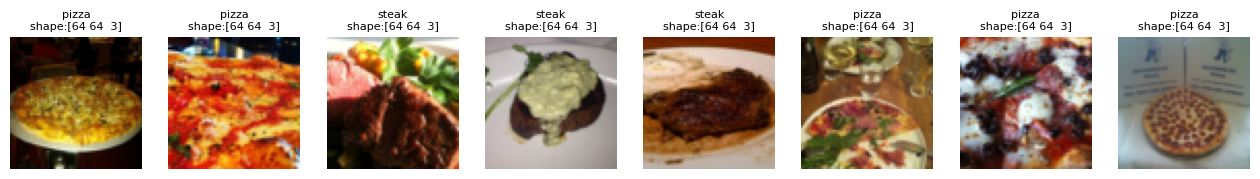

In [38]:
plot_random_images(ctest_data, ctest_data.classes, 8, seed=42)

#### **4.2.4 Dataloaders**

In [39]:
BATCH_SIZE = 2
WORKERS = multiprocessing.cpu_count()
ctest_dataloader = DataLoader(ctest_data, batch_size = BATCH_SIZE, shuffle=True, num_workers=WORKERS)
ctrain_dataloader = DataLoader(ctrain_data, BATCH_SIZE, False, num_workers=WORKERS)

ctest_dataloader, ctrain_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ef6d315f7c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ef6d315dc30>)

In [40]:
len(ctest_dataloader), len(ctrain_dataloader)

(38, 113)

In [41]:
c_sample_img, c_sample_lbl = next(iter(ctest_dataloader))

print(c_sample_img.shape, c_sample_lbl.shape)

torch.Size([2, 3, 64, 64]) torch.Size([2])


## **5. Data argumentation**

In [42]:
arg_transform_train = transforms.Compose([
    transforms.Resize((244,244)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

arg_transform_test = transforms.Compose([
    transforms.Resize((244,244)),
    transforms.ToTensor()
])

In [43]:
len(all_images)

300

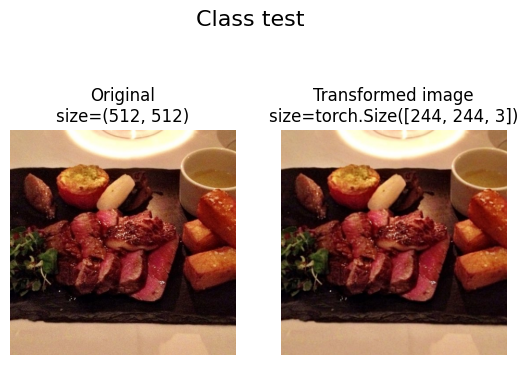

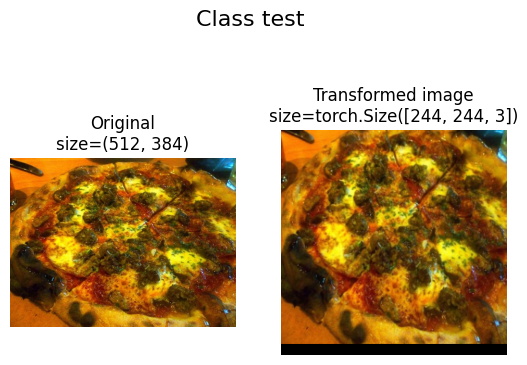

In [44]:
plot_transformed_image(all_images, arg_transform_train, 2)

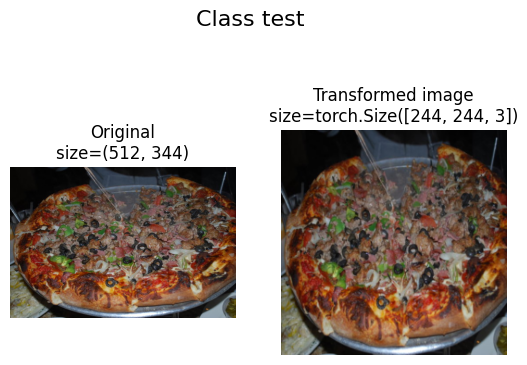

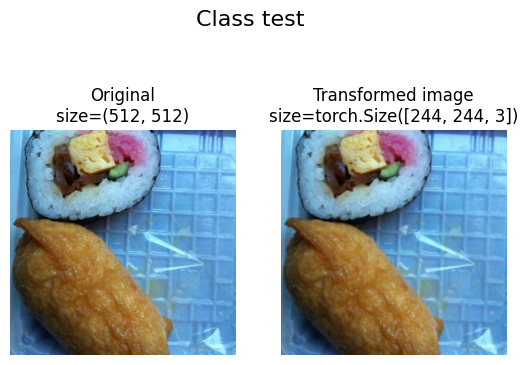

In [45]:
plot_transformed_image(all_images, arg_transform_test, 2)

## **6. Model building**

### **6.1 Data reading and data loading**

In [46]:
train_dir, test_dir

(PosixPath('/content/drive/MyDrive/Colab Notebooks YouTube tutorials/8.1 PyTorch/01_Daniel Bourke/data/05_food/Images/train'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks YouTube tutorials/8.1 PyTorch/01_Daniel Bourke/data/05_food/Images/test'))

In [47]:
# Define data transforms

simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

# Data reading
simple_test_data = datasets.ImageFolder(test_dir, simple_transform)
simple_train_data = datasets.ImageFolder(train_dir, simple_transform)

# Dataloader
WORKERS = multiprocessing.cpu_count()
BATCH_SIZE = 32

simple_test_dataloader = DataLoader(simple_test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
simple_train_dataloader = DataLoader(simple_train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)


In [48]:
print(f"Total Images in trian dir = {len(simple_train_data)}")
print(f"Total Images in test dir = {len(simple_test_data)}")

print(f"Total batches in train = {len(simple_train_dataloader)}")
print(f"Total batches in test = {len(simple_test_dataloader)}")

print(f"By manual calculation : train batch =  {math.ceil(len(simple_train_data)/ BATCH_SIZE)}, test batch = {math.ceil(len(simple_test_data)/BATCH_SIZE)}")

Total Images in trian dir = 225
Total Images in test dir = 75
Total batches in train = 8
Total batches in test = 3
By manual calculation : train batch =  8, test batch = 3


### **6.2 Model building Tiny-VGG - [brrr](https://horace.io/brrr_intro.html)**

In [49]:
class TinyVGG(t.nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int) -> None:
        super().__init__()
        self.block1 = t.nn.Sequential(
            t.nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1), # stride same as kernal_size
            t.nn.ReLU(),
            t.nn.Conv2d(hidden_units, hidden_units, 3, 1),
            t.nn.ReLU(),
            t.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block2 = t.nn.Sequential(
            t.nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1), # stride same as kernal_size
            t.nn.ReLU(),
            t.nn.Conv2d(hidden_units, hidden_units, 3, 1),
            t.nn.ReLU(),
            t.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block3 = t.nn.Sequential(
            t.nn.Flatten(),
            t.nn.Linear(in_features=13*13*10, out_features=output_shape)
        )

    def forward(self, x):
        x = self.block1(x)
        # print(x.shape)
        x = self.block2(x)
        # print(x.shape)
        x = self.block3(x)
        # print(x.shape)

        return x

In [50]:
model0 = TinyVGG(3,10,3)
model0

TinyVGG(
  (block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [51]:
img_batch, lbl_batch = next(iter(simple_train_dataloader))

img_batch.shape, lbl_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [52]:
model0(img_batch)

tensor([[-0.0179,  0.0355,  0.0188],
        [-0.0172,  0.0355,  0.0186],
        [-0.0165,  0.0372,  0.0187],
        [-0.0157,  0.0348,  0.0176],
        [-0.0169,  0.0356,  0.0194],
        [-0.0169,  0.0349,  0.0188],
        [-0.0158,  0.0350,  0.0189],
        [-0.0173,  0.0349,  0.0187],
        [-0.0163,  0.0352,  0.0184],
        [-0.0174,  0.0358,  0.0198],
        [-0.0139,  0.0337,  0.0196],
        [-0.0155,  0.0345,  0.0192],
        [-0.0172,  0.0350,  0.0192],
        [-0.0152,  0.0356,  0.0183],
        [-0.0154,  0.0357,  0.0203],
        [-0.0156,  0.0358,  0.0184],
        [-0.0172,  0.0354,  0.0190],
        [-0.0166,  0.0347,  0.0187],
        [-0.0157,  0.0349,  0.0187],
        [-0.0167,  0.0364,  0.0179],
        [-0.0164,  0.0349,  0.0184],
        [-0.0170,  0.0347,  0.0189],
        [-0.0172,  0.0352,  0.0194],
        [-0.0158,  0.0341,  0.0194],
        [-0.0165,  0.0340,  0.0179],
        [-0.0162,  0.0362,  0.0183],
        [-0.0155,  0.0346,  0.0189],
 

### **6.3 Model info**

In [53]:
try:
    import torchinfo
except:
    !pip install torchinfo -q
from torchinfo import summary
summary(model0, input_size=(1,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [54]:
from torchsummary import summary

summary(model0, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 62, 62]             280
              ReLU-2           [-1, 10, 62, 62]               0
            Conv2d-3           [-1, 10, 60, 60]             910
              ReLU-4           [-1, 10, 60, 60]               0
         MaxPool2d-5           [-1, 10, 30, 30]               0
            Conv2d-6           [-1, 10, 28, 28]             910
              ReLU-7           [-1, 10, 28, 28]               0
            Conv2d-8           [-1, 10, 26, 26]             910
              ReLU-9           [-1, 10, 26, 26]               0
        MaxPool2d-10           [-1, 10, 13, 13]               0
          Flatten-11                 [-1, 1690]               0
           Linear-12                    [-1, 3]           5,073
Total params: 8,083
Trainable params: 8,083
Non-trainable params: 0
-----------------------------------

### **6.4 Train and test loop**

In [55]:
# Creating the function for train and test

def train_step(model:t.nn.Module, data:DataLoader, loss:t.nn.Module, optimizer:t.optim.Optimizer, device:t.device) -> tuple[t.Tensor, float]:
    model.train()
    train_loss, train_accuracy = 0,0

    pbar = tqdm(range(len(data)), unit="batchs")
    for batch,(X,y) in enumerate(data):
        X, y = X.to(device), y.to(device)

        y_logits = model(X)

        loss_per_batch = loss(y_logits, y)
        acc_per_batch = sum(t.argmax(t.softmax(y_logits, 1), 1)==y).item() / len(y)

        optimizer.zero_grad()
        loss_per_batch.backward()
        optimizer.step()

        train_loss += loss_per_batch
        train_accuracy +=acc_per_batch

        pbar.update(1)
    pbar.close()
    train_loss /= len(data)
    train_accuracy /= len(data)

    return train_accuracy, train_loss

def test_step(model:t.nn.Module, data:DataLoader, loss:t.nn.Module, optimizer:t.optim.Optimizer, device:t.device) -> tuple[t.Tensor, float]:
    model.eval()

    test_loss, test_accuracy = 0,0

    with t.inference_mode():
        for batch,(X,y) in enumerate(data):
            # print(type(X), X.shape)
            # print(type(y), y)
            X,y = X.to(device), y.to(device)

            y_logits = model(X)

            loss_per_batch = loss(y_logits, y)
            acc_per_batch = sum(t.argmax(t.softmax(y_logits, 1), 1) == y).item() / len(y)

            test_loss += loss_per_batch
            test_accuracy += acc_per_batch

        test_loss /= len(data)
        test_accuracy /= len(data)

    return test_accuracy, test_loss

In [56]:
t# Train function

def train(model:t.nn.Module, train_data:DataLoader, test_data:DataLoader,
          loss:t.nn.Module, optimizer:t.optim.Optimizer,
          device:t.device, epochs:int) -> dict[str,list]:

    results = {'train_acc':[], 'train_loss':[], 'test_acc':[], 'test_loss':[]}


    pbar = tqdm(range(1,epochs+1), "Overall training progress", unit='epoch')
    for epoch in range(1, epochs+1):
        train_acc, train_loss = train_step(model, train_data, loss, optimizer, device)
        test_acc, test_loss = test_step(model, test_data, loss, optimizer, device)

        print(f"{epoch}/{epochs} | train:acc={train_acc:.2f}%, loss={train_loss:.4f} | test:acc={test_acc:.2f}%, loss={test_loss:.4f}")

        results['train_acc'].append(train_acc)
        results['train_loss'].append((train_loss).item())
        results['test_acc'].append(test_acc)
        results['test_loss'].append((test_loss).item())

        pbar.update(1)
    pbar.close()

    return results


In [57]:
NUM_EPOCHS = 5

model0 = TinyVGG(3, 10, 3).to(device)

loss = t.nn.CrossEntropyLoss()
optimizer = t.optim.SGD(model0.parameters(), lr=0.001)

st = timer()
res0 = train(model0, simple_train_dataloader, simple_test_dataloader, loss, optimizer, device, NUM_EPOCHS)
print(f"Total time taken = {timer()-st}")

Overall training progress:   0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/8 [00:00<?, ?batchs/s]

1/5 | train:acc=0.30%, loss=1.0990 | test:acc=0.36%, loss=1.0978


  0%|          | 0/8 [00:00<?, ?batchs/s]

2/5 | train:acc=0.43%, loss=1.0964 | test:acc=0.32%, loss=1.0985


  0%|          | 0/8 [00:00<?, ?batchs/s]

3/5 | train:acc=0.30%, loss=1.0992 | test:acc=0.30%, loss=1.0986


  0%|          | 0/8 [00:00<?, ?batchs/s]

4/5 | train:acc=0.43%, loss=1.0959 | test:acc=0.32%, loss=1.0984


  0%|          | 0/8 [00:00<?, ?batchs/s]

5/5 | train:acc=0.30%, loss=1.0999 | test:acc=0.34%, loss=1.0984
Total time taken = 38.707828081


In [58]:
res0

{'train_acc': [0.3046875, 0.42578125, 0.3046875, 0.42578125, 0.3046875],
 'train_loss': [1.0990407466888428,
  1.0963884592056274,
  1.0992116928100586,
  1.0959491729736328,
  1.0998754501342773],
 'test_acc': [0.35984848484848486,
  0.32007575757575757,
  0.300189393939394,
  0.32007575757575757,
  0.33996212121212127],
 'test_loss': [1.097762942314148,
  1.0984503030776978,
  1.0986205339431763,
  1.0984350442886353,
  1.0983874797821045]}

### **6.5 Plotting the loss and accuracy**

In [59]:
def plot_model(result:dict[str, list]) -> None:
    plt.figure(figsize=(15,5))

    # plotting accuracy
    plt.subplot(1,2,1)
    plt.plot(result['train_acc'], label='train-accuracy')
    plt.plot(result['test_acc'], label='test-accuracy')
    plt.title("Accuracy-plot")
    plt.legend()

    # plotting loss
    plt.subplot(1,2,2)
    plt.plot(result['train_loss'], label='train-loss')
    plt.plot(result['test_loss'], label='test-loss')
    plt.title("Loss-plot")
    plt.legend()


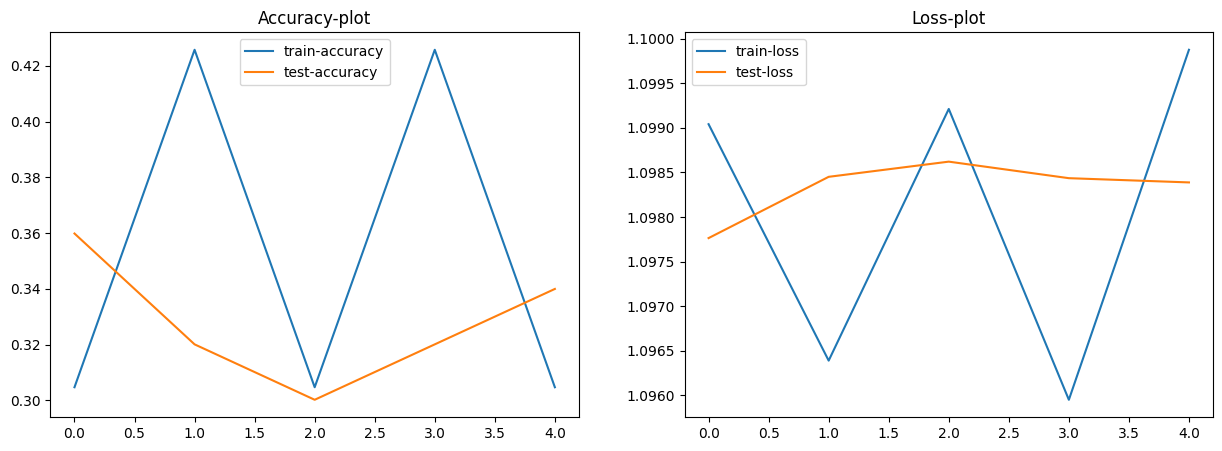

In [60]:
plot_model(res0)

## **7. Improve model**

### **7.1 Data argumentation**

In [61]:
train_arg_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

### **7.2 Data reading**

In [62]:
train_arg_data = datasets.ImageFolder(train_dir, train_arg_transform)
simple_test_data = datasets.ImageFolder(test_dir, test_transform)

print(train_arg_data[0][0].shape, train_arg_data[0][1])
len(train_arg_data), len(simple_test_data)

torch.Size([3, 64, 64]) 0


(225, 75)

In [63]:
train_arg_data.classes

['pizza', 'steak', 'sushi']

In [64]:
train_arg_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

### **7.3 DataLoader**

In [65]:
train_arg_dataloader = DataLoader(train_arg_data, 32, shuffle=True)
test_dataloader = DataLoader(simple_test_data, 32, True)

print(len(train_arg_dataloader), len(test_dataloader))

8 3


### **7.4 Model building**

In [66]:
model1 = TinyVGG(3,10,3).to(device)

model1

TinyVGG(
  (block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [67]:
EPOCHS = 5

loss = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model1.parameters(), lr=0.01)

st = timer()
model1_res = train(model1, train_arg_dataloader, test_dataloader, loss, optimizer, device, EPOCHS)

print(f"Total time taken for training = {timer()-st}seconds")

Overall training progress:   0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/8 [00:00<?, ?batchs/s]

1/5 | train:acc=0.26%, loss=1.1150 | test:acc=0.38%, loss=1.0981


  0%|          | 0/8 [00:00<?, ?batchs/s]

2/5 | train:acc=0.28%, loss=1.1024 | test:acc=0.40%, loss=1.0946


  0%|          | 0/8 [00:00<?, ?batchs/s]

3/5 | train:acc=0.28%, loss=1.1023 | test:acc=0.42%, loss=1.0961


  0%|          | 0/8 [00:00<?, ?batchs/s]

4/5 | train:acc=0.28%, loss=1.0988 | test:acc=0.36%, loss=1.0973


  0%|          | 0/8 [00:00<?, ?batchs/s]

5/5 | train:acc=0.43%, loss=1.0942 | test:acc=0.32%, loss=1.1002
Total time taken for training = 23.124068705000013seconds


In [68]:
model1_res

{'train_acc': [0.26171875, 0.28125, 0.28125, 0.28125, 0.42578125],
 'train_loss': [1.1149647235870361,
  1.1024222373962402,
  1.1023437976837158,
  1.0988277196884155,
  1.0942009687423706],
 'test_acc': [0.38257575757575757,
  0.40246212121212127,
  0.42234848484848486,
  0.35984848484848486,
  0.32007575757575757],
 'test_loss': [1.0981101989746094,
  1.0946160554885864,
  1.0960825681686401,
  1.0973445177078247,
  1.1001942157745361]}

### **7.5 Plot model**

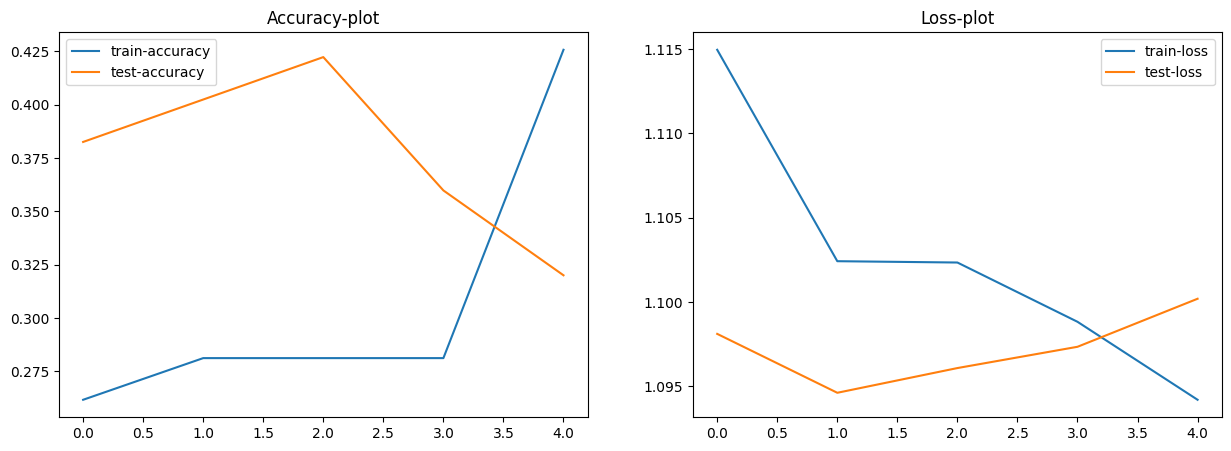

In [69]:
plot_model(model1_res)

## **8. Model predictions**

### **8.1 Download image**

In [70]:
zip_file

PosixPath('/content/drive/MyDrive/Colab Notebooks YouTube tutorials/8.1 PyTorch/01_Daniel Bourke/data/05_food')

In [71]:
file_name = zip_file / "pizza.jpg"

if not file_name.is_file():
    print("File does not exists...")
    with open(file_name, 'wb') as f:
        content = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true").content
        print("Downloading...")
        f.write(content)
else:
    print("File exists...")

File exists...


### **8.2 Image pre-processing**

In [72]:
model_input = tv.io.read_image(str(file_name))

model_input.shape, model_input.dtype

(torch.Size([3, 4032, 3024]), torch.uint8)

In [78]:
model_input[0][0]

tensor([154, 173, 181,  ...,  21,  18,  14], dtype=torch.uint8)

In [81]:
model_input = model_input.type(t.float32)

model_input[0][0], model_input.dtype

(tensor([154., 173., 181.,  ...,  21.,  18.,  14.]), torch.float32)

In [76]:
pil_input = Image.open(file_name)
print(type(pil_input))

<class 'PIL.JpegImagePlugin.JpegImageFile'>


### **8.3 Image transform**

In [84]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

transformed_img = transform(pil_input)
transformed_img.dtype, transformed_img[0][0], transformed_img.shape

(torch.float32,
 tensor([0.4667, 0.5294, 0.5608, 0.5569, 0.6078, 0.5333, 0.5412, 0.6078, 0.6824,
         0.5412, 0.4078, 0.5922, 0.6941, 0.5529, 0.7569, 0.8784, 0.7882, 0.4667,
         0.6000, 0.7216, 0.5490, 0.7333, 0.8706, 0.7176, 0.6275, 0.8275, 0.8431,
         0.8196, 0.7176, 0.4941, 0.5333, 0.5176, 0.5098, 0.4588, 0.5451, 0.9412,
         0.9608, 0.9608, 0.9490, 0.8706, 0.7529, 0.6863, 0.6667, 0.6157, 0.5765,
         0.5608, 0.5451, 0.5490, 0.6157, 0.6196, 0.6157, 0.5804, 0.5529, 0.5529,
         0.5255, 0.4588, 0.2039, 0.1529, 0.1647, 0.1098, 0.0902, 0.0980, 0.0588,
         0.0588]),
 torch.Size([3, 64, 64]))

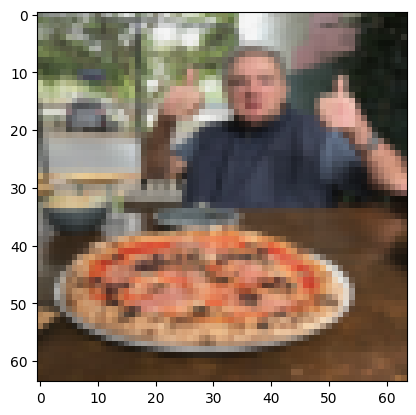

In [86]:
plt.imshow(transformed_img.permute(1,2,0));
# plt.axis('off');

### **8.4 Model predictions**

In [93]:
model1.eval()
with t.inference_mode():
    pred_logits = model1(transformed_img.unsqueeze(0))
    pred_probs = t.softmax(pred_logits, 1)
    pred_lbl = t.argmax(pred_probs, 1)

In [94]:
print(f"{pred_logits = }\n{pred_probs = }\n{pred_lbl = }")

pred_logits = tensor([[ 0.0337, -0.0243, -0.0275]])
pred_probs = tensor([[0.3467, 0.3272, 0.3261]])
pred_lbl = tensor([0])


In [91]:
train_data.classes[pred_probs.item()]

'pizza'

### **8.5 Function in prediction**

In [108]:
def predict(model:t.nn.Module, img:str, labels:list[str], device:t.device, transform:transforms.Compose|None=None):
    img_data = Image.open(img)
    if transform:
        transformed = transform(img_data)

    model.eval()
    with t.inference_mode():
        pred_logits = model(transformed.unsqueeze(0).to(device))
        pred_prob = t.softmax(pred_logits, 1)
        pred_lbl = t.argmax(pred_prob, 1)

    label = labels[pred_lbl.item()]
    prob = pred_prob.max()

    # plotting
    plt.imshow(transformed.permute(1,2,0).to(device))
    plt.title(f"{label = } | {prob = }")
    plt.axis('off');

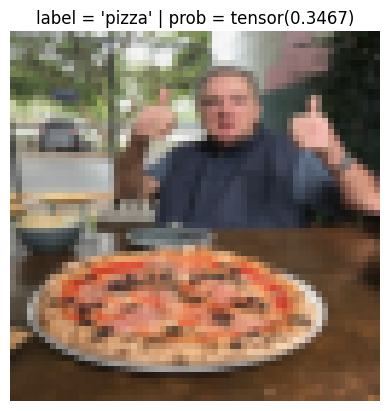

In [111]:
# @title Predict image { run: "auto", vertical-output: true, display-mode: "both" }
variable_name = model0 # @param ["model0", "model1"] {type:"raw", allow-input: true}
predict(model1, str(file_name), train_data.classes, device, transform)

# **📖 Notes**

### **Types of data and dataloaders in PyTorch - [refer](https://pytorch.org/data/beta/index.html)**
- TorchVision
- TorchAudio
- TorchText
- TorchRec
- TorchData

### **Important functions**
- `ravel` -> numpy
- `permute` and `concatenate` -> pytorch

### **TensorFlow**
- [Load dataset](https://www.tensorflow.org/tutorials/images/classification)

### **PyTorch**
- [Load image data](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html)


### **Improve the model**
- Increase layers
- Increase neurons
- Change activation function
- Change loss function
- Change optimizer
- Change learning rate

### **Overfitting**

| **Method to prevent overfitting** | **What is it?** |
| ----- | ----- |
| **Get more data** | Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples. |
| **Simplify your model** | If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer. |
| **Use data augmentation** | [**Data augmentation**](https://developers.google.com/machine-learning/glossary#data-augmentation) manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data. |
| **Use transfer learning** | [**Transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning) involves leveraging the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images. |
| **Use dropout layers** | Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model but also making the remaining connections better. See [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) for more. |
| **Use learning rate decay** | The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to [**convergence**](https://developers.google.com/machine-learning/glossary#convergence), the smaller you'll want your weight updates to be.  |
| **Use early stopping** | [**Early stopping**](https://developers.google.com/machine-learning/glossary#early_stopping) stops model training *before* it begins to overfit. As in, say the model's loss has stopped decreasing for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model weights that had the lowest loss (10 epochs prior). |

### **Underfitting**
| **Method to prevent underfitting** | **What is it?** |
| ----- | ----- |
| **Add more layers/units to your model** | If your model is underfitting, it may not have enough capability to *learn* the required patterns/weights/representations of the data to be predictive. One way to add more predictive power to your model is to increase the number of hidden layers/units within those layers. |
| **Tweak the learning rate** | Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything. In this case, you might lower the learning rate and see what happens. |
| **Use transfer learning** | Transfer learning is capable of preventing overfitting and underfitting. It involves using the patterns from a previously working model and adjusting them to your own problem. |
| **Train for longer** | Sometimes a model just needs more time to learn representations of data. If you find in your smaller experiments your model isn't learning anything, perhaps leaving it train for a more epochs may result in better performance. |
| **Use less regularization** | Perhaps your model is underfitting because you're trying to prevent overfitting too much. Holding back on regularization techniques can help your model fit the data better. |

### **Check-1 [Brrr](https://horace.io/brrr_intro.html)**
### **Schedule learning rate - [Doc](https://pytorch.org/docs/stable/optim.html)**
___